# Parse IFC file

In [1]:
import re

import ifcopenshell as ifc

In [2]:
bim = ifc.open('../assets/private/histo.ifc')

## List of named spaces

In [3]:
from ifcopenshell import geom as ifc_geom
from ifcopenshell.util import shape as ifc_shape

import pandas as pd

settings = ifc_geom.settings()
settings.set(settings.USE_WORLD_COORDS, True)  # Find global coordinates

def get_area(x):
    shape = ifc_geom.create_shape(settings, x)
    geom = shape.geometry
    return ifc_shape.get_footprint_area(geom)

def get_centroid(x):
    shape = ifc_geom.create_shape(settings, x)
    geom = shape.geometry
    x, y, z = ifc_shape.get_bbox_centroid(geom)
    z = ifc_shape.get_shape_bottom_elevation(shape, geom)
    return (x, y)

def get_bottom_elevation(x):
    shape = ifc_geom.create_shape(settings, x)
    geom = shape.geometry
    z = ifc_shape.get_shape_bottom_elevation(shape, geom)
    return z

spaces = [
    x for x in bim.by_type('IfcSpace') if x.Description is not None
]

data = [
    {
        'id': x.id(),
        'description': re.sub(r'\s+', ' ', x.Description).lower(),
        'area': get_area(x),
        'centroid': get_centroid(x),
        'elevation': get_bottom_elevation(x)
    }
    for x in spaces
]

df = pd.DataFrame(data)
df

,id,description,area,centroid,elevation
0,28043,digital pathology,12.651152,"(87.03472352338409, 56.17319426046849)",7.0
1,29674,cupboard (2),5.490400,"(52.608376794667244, 57.86986107222323)",10.5
2,29797,cupboard (2),3.311260,"(55.093809889638976, 61.2673610722232)",10.5
3,29949,white room cut-up,26.102966,"(69.29587679466721, 63.49391196897475)",10.5
4,30130,cupboard (1),0.883575,"(54.4896267946672, 58.4548610722233)",10.5
5,30631,filing room,14.239375,"(49.868376794667235, 56.22111107222329)",10.5
6,30884,ladies toilet,10.598825,"(56.58212679466716, 63.997361072223185)",10.5
7,31018,ladies toilet,6.074083,"(57.68212679466721, 63.0761110722232)",10.5
8,31182,cupboard (1),0.494019,"(52.8371267946672, 61.741111072223276)",10.5
9,31300,main lab section leaders,16.412656,"(52.93212679466719, 63.5473610722232)",10.5


In [4]:
import matplotlib.pyplot as plt
from histopath_bim_des.bim import BimModel

bim_model = BimModel.from_ifc('../assets/private/histo.ifc')
l3_model = bim_model.to_shapely(level=3)
l4_model = bim_model.to_shapely(level=4)

In [5]:
bim_model.elevations

{'Level 1 Basement': 0.0,
 'Level 2 Ground floor bottom line': 3.03,
 'Level 2 Ground floor': 3.5,
 'Level 3 First floor bottom line': 6.53,
 'Level 3 First floor': 7.0,
 'Level 4 Second floor bottom line': 10.03,
 'Level 4 Second floor': 10.5,
 'Level 5 Third floor bottom line': 13.53,
 'Level 5 Third floor': 14.0,
 'Level 6 Fourth floor bottom line': 17.03,
 'Level 6 Fourth floor': 17.5,
 'Level 7 Roof': 21.0}

In [6]:
l3_spaces = df.loc[df.elevation == bim_model.elevations['Level 3 First floor'], :]
list(l3_spaces.id)

[28043]

In [7]:
l4_spaces = df.loc[df.elevation == bim_model.elevations['Level 4 Second floor'], :]
list(l4_spaces.id)

[29674,
 29797,
 29949,
 30130,
 30631,
 30884,
 31018,
 31182,
 31300,
 31527,
 31975,
 32585,
 32926,
 33080,
 35691,
 35847,
 38928,
 39187,
 39324,
 39516,
 39716,
 39962,
 40107,
 53160,
 53329,
 67825]

In [8]:
for p, desc in zip(l4_spaces.centroid, l4_spaces.description):
    x, y = p
    print(x,y, desc)

52.608376794667244 57.86986107222323 cupboard (2)
55.093809889638976 61.2673610722232 cupboard (2)
69.29587679466721 63.49391196897475 white room cut-up
54.4896267946672 58.4548610722233 cupboard (1)
49.868376794667235 56.22111107222329 filing room
56.58212679466716 63.997361072223185 ladies toilet
57.68212679466721 63.0761110722232 ladies toilet
52.8371267946672 61.741111072223276 cupboard (1)
52.93212679466719 63.5473610722232 main lab section leaders
41.76212679466717 59.87486107222324 main lab
85.8472988924587 63.53346044800768 specimen storage
67.9946267946672 61.14141196897481 cupboard (2)
81.50980171605323 61.17236107222321 cupboard (2)
80.18117541283571 63.53346044800772 green room cut-up
48.50712679466719 63.499861072223204 staining room
47.162126794667174 56.221111072223295 block & slide
74.69587679466721 62.11736107222332 ventilated stores
65.27212679466719 61.932361072223316 bandsaw
78.93510577547728 56.17236107222311 processing room (embedding)
72.08962679466718 56.2211110

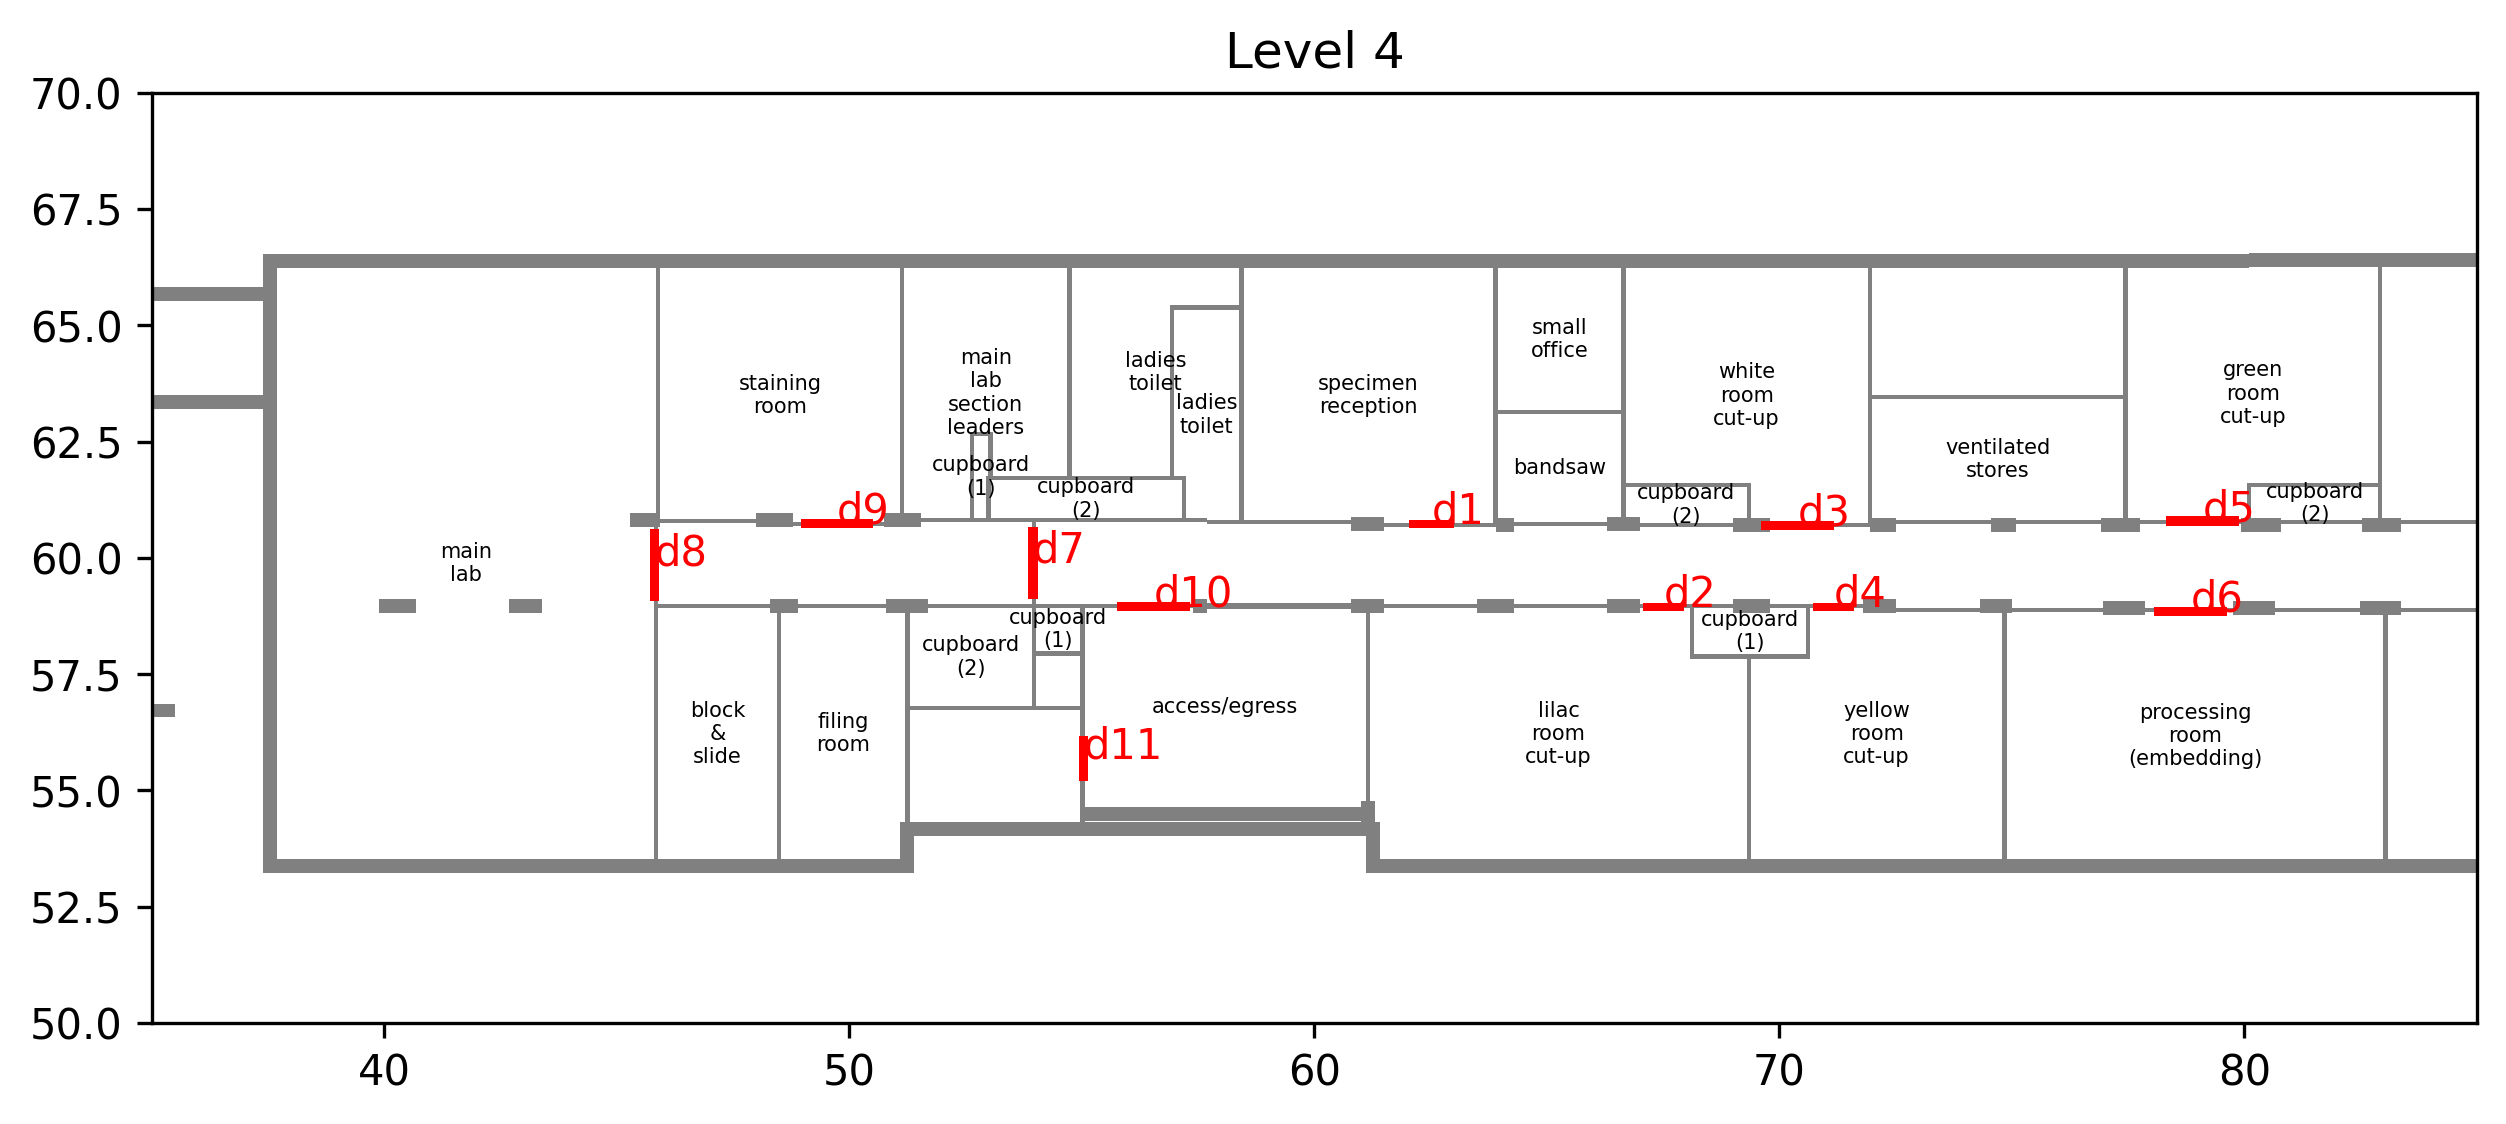

In [9]:
fig = plt.figure(figsize=(10,5), dpi=300)
ax=fig.subplots()
l4_model.plot_floor(ax, 'Level 4', bottom_left=(35,50), top_right=(85,70))

for p, desc in zip(l4_spaces.centroid, l4_spaces.description):
    x, y = p
    ax.annotate(re.sub(r'\s+', '\n', desc),
                (x, y),
                fontsize=5,
                horizontalalignment='center',
                verticalalignment='center')
    

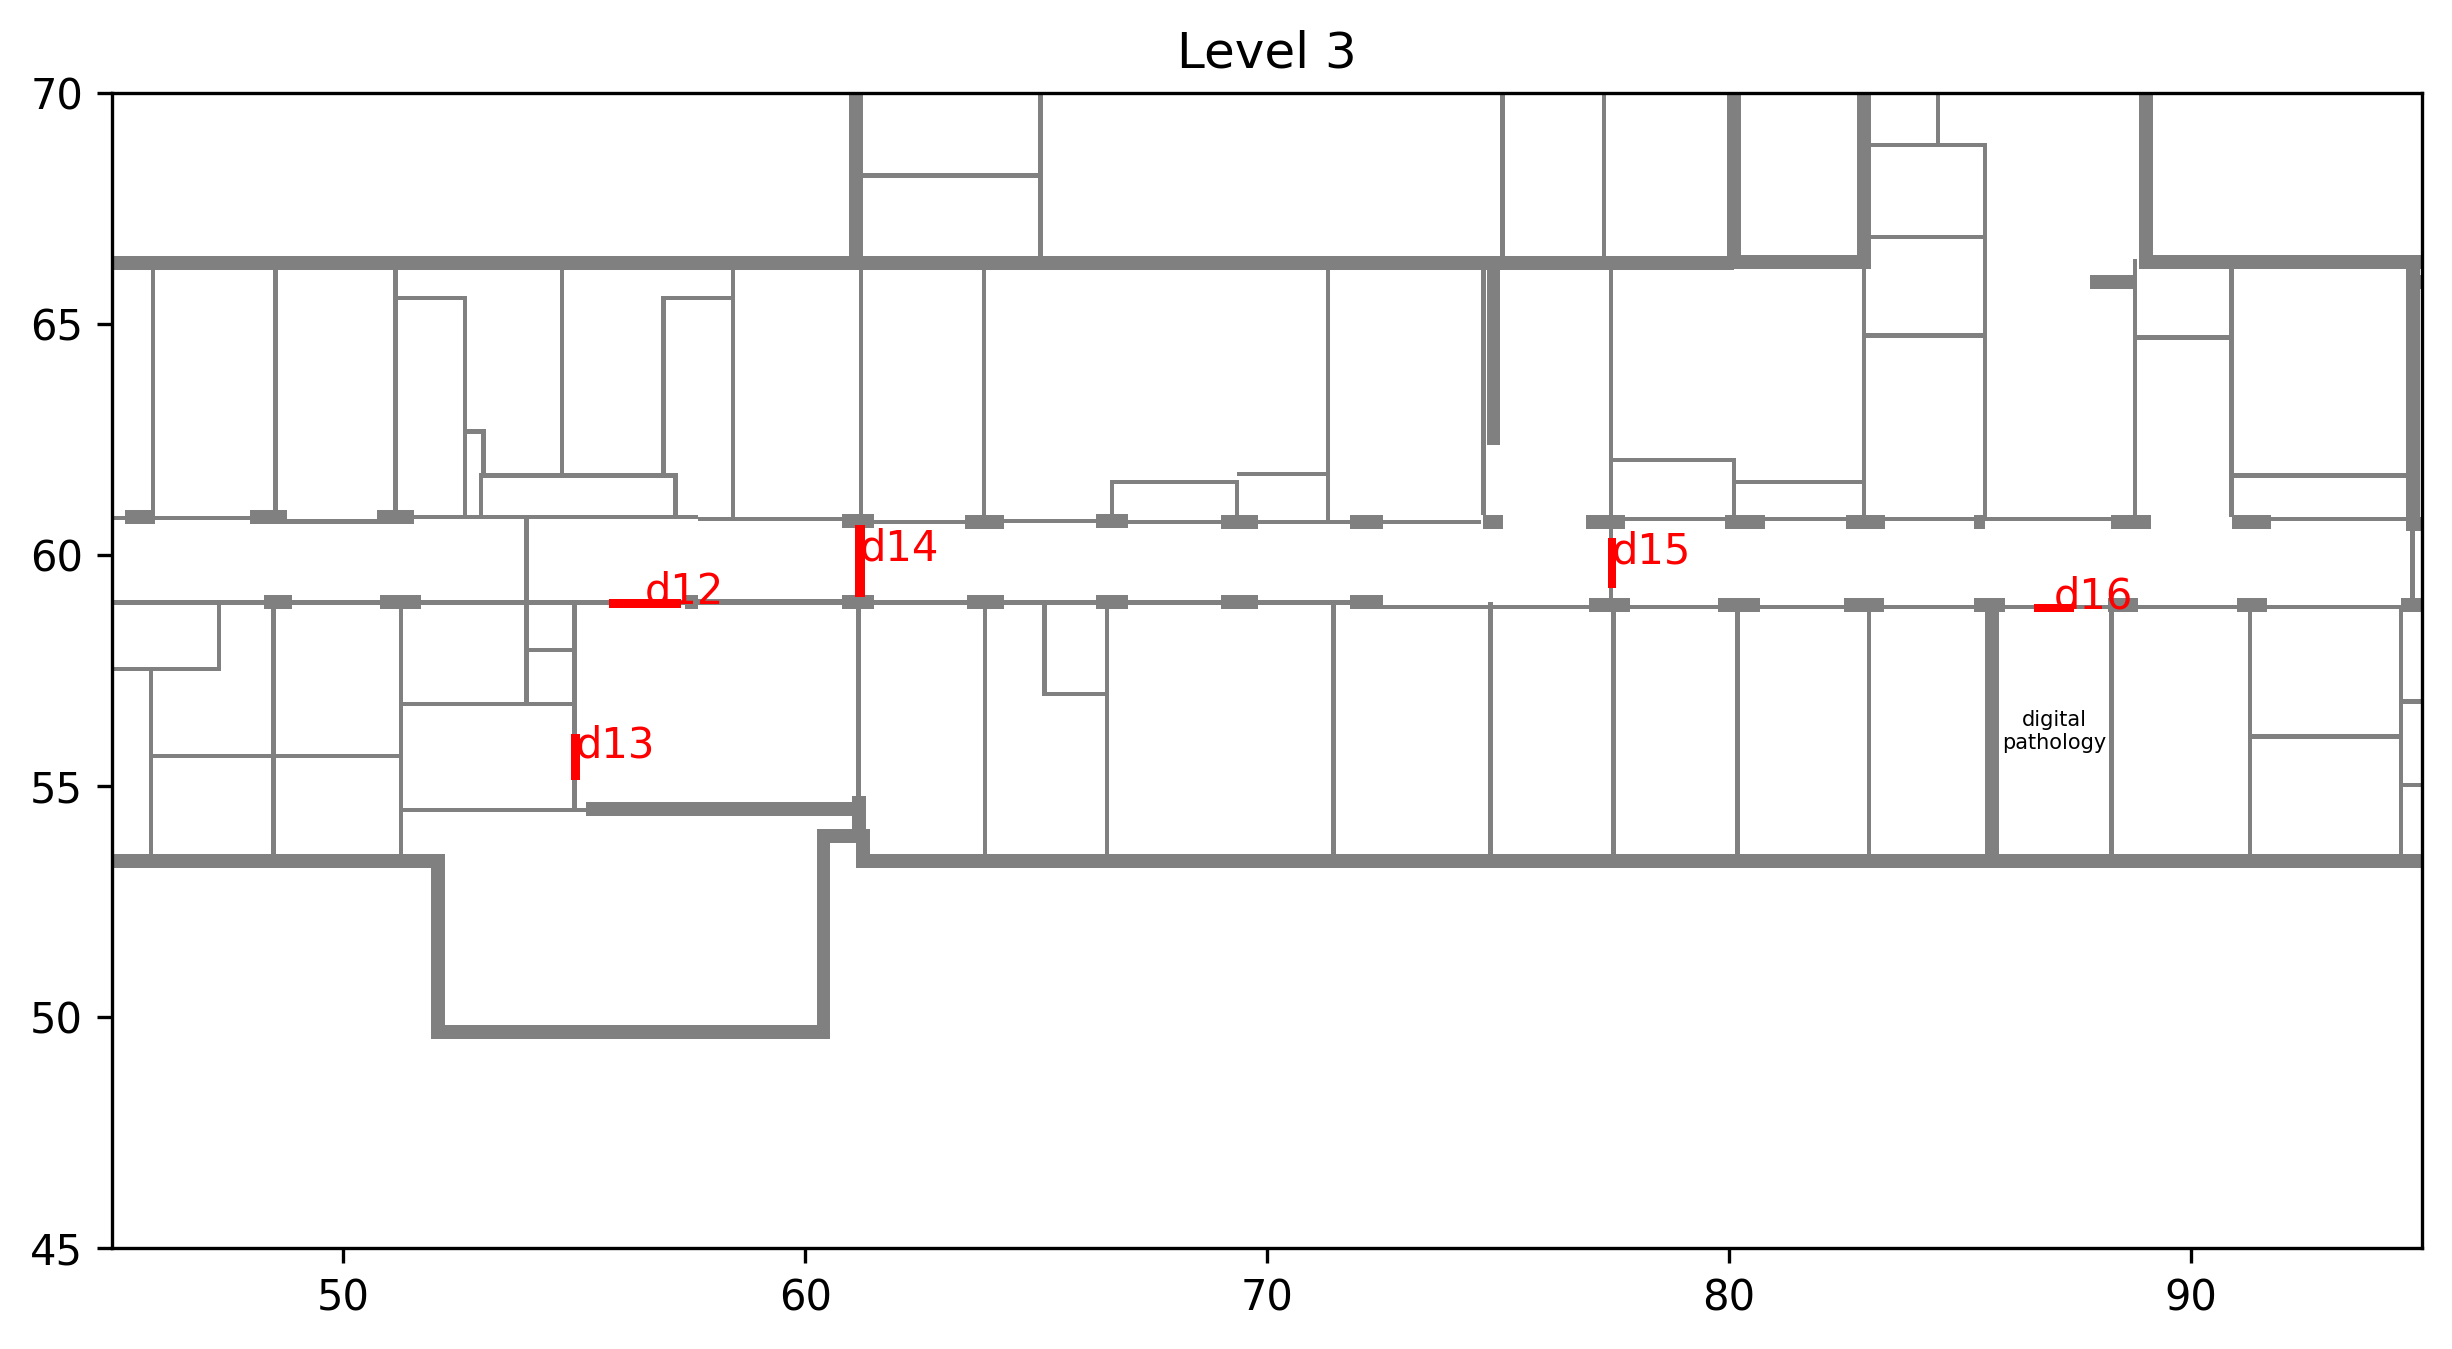

In [10]:
fig = plt.figure(figsize=(10,5), dpi=300)
ax=fig.subplots()
l3_model.plot_floor(ax, 'Level 3', bottom_left=(45,45), top_right=(95,70))

for p, desc in zip(l3_spaces.centroid, l3_spaces.description):
    x, y = p
    ax.annotate(re.sub(r'\s+', '\n', desc),
                (x, y),
                fontsize=5,
                horizontalalignment='center',
                verticalalignment='center')